In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import scipy.io as sio
from scipy.ndimage import gaussian_filter
import random
import logging

# Dataset root path
DATASET_ROOT = r"C:\Users\ARTI\OneDrive\Documents\cm\ShanghaiTech"

# Logging
logging.basicConfig(level=logging.INFO, format="[INFO] %(message)s")

# Seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [2]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])


def load_image_rgb(path):
    img = Image.open(path).convert("RGB")
    return img_transform(img)


def load_density_map(mat_path, downsample=8):
    mat = sio.loadmat(mat_path)
    points = mat["image_info"][0, 0][0, 0][0]

    # Create blank map based on maximum resolution (Part B size)
    h, w = 768, 1024
    density = np.zeros((h, w), dtype=np.float32)

    for x, y in points:
        if 0 <= int(y) < h and 0 <= int(x) < w:
            density[int(y), int(x)] = 1.0

    density = gaussian_filter(density, sigma=4)

    # Downsample
    density_ds = density[::downsample, ::downsample]
    density_ds *= (downsample * downsample)

    return torch.tensor(density_ds).unsqueeze(0)

In [3]:
class ShanghaiTechDataset(Dataset):
    def __init__(self, root_dir, part, split):
        self.root_dir = Path(root_dir)
        self.part = part
        self.split = split

        base = self.root_dir / f"part_{part}" / f"{split}_data"
        self.img_paths = sorted((base / "images").glob("*.jpg"))
        self.gt_paths  = sorted((base / "ground-truth").glob("*.mat"))

        if len(self.img_paths) != len(self.gt_paths):
            raise RuntimeError("Mismatch: image and GT file count differ")

        logging.info(f"Loaded {len(self.img_paths)} samples from Part {part} {split}")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        gt_path  = self.gt_paths[idx]

        img_t = load_image_rgb(img_path)
        den_t = load_density_map(gt_path)

        meta = {
            "img_path": str(img_path),
            "gt_path": str(gt_path),
            "density_sum": float(den_t.sum())
        }

        return img_t, den_t, meta

In [4]:
# Preprocess Part A + Part B (train + test)
all_data = {}

for part in ["A", "B"]:
    for split in ["train", "test"]:
        logging.info(f"Processing Part {part} — {split}")

        dataset = ShanghaiTechDataset(DATASET_ROOT, part, split)
        loader = DataLoader(dataset, batch_size=1, shuffle=False)

        images = []
        densities = []
        metas = []

        for img_t, den_t, meta in loader:
            images.append(img_t.squeeze(0))
            densities.append(den_t.squeeze(0))
            metas.append(meta)

        all_data[f"{part}_{split}"] = {
            "images": images,
            "densities": densities,
            "metas": metas
        }

logging.info("Finished preprocessing all Parts A + B.")

[INFO] Processing Part A — train
[INFO] Loaded 300 samples from Part A train
[INFO] Processing Part A — test
[INFO] Loaded 182 samples from Part A test
[INFO] Processing Part B — train
[INFO] Loaded 400 samples from Part B train
[INFO] Processing Part B — test
[INFO] Loaded 316 samples from Part B test
[INFO] Finished preprocessing all Parts A + B.


[INFO] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Showing samples from Part A_train


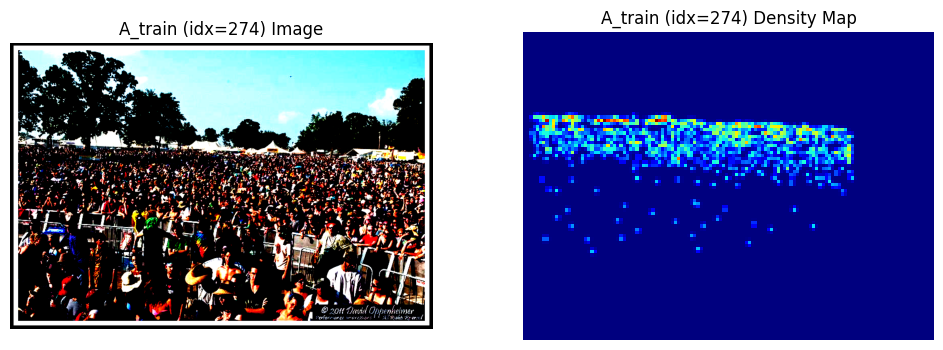

[INFO] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


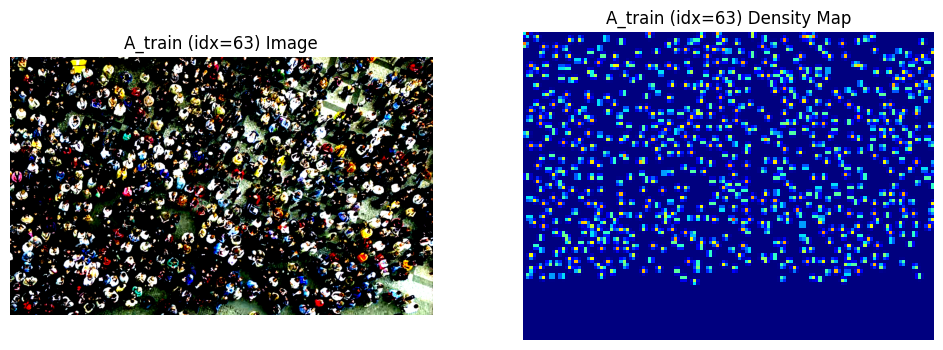

[INFO] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Showing samples from Part A_test


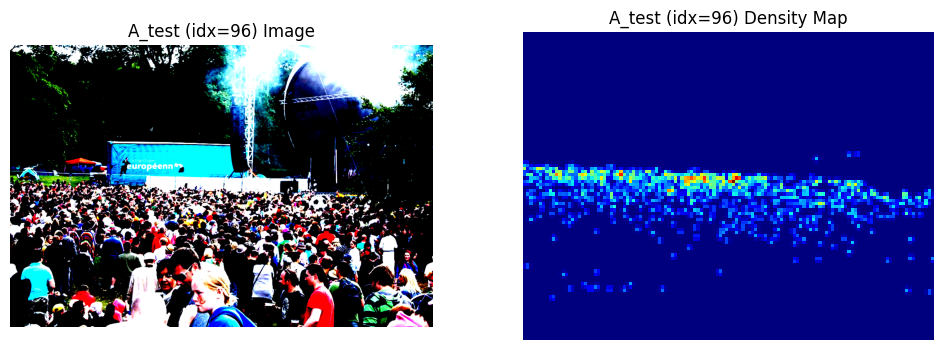

[INFO] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


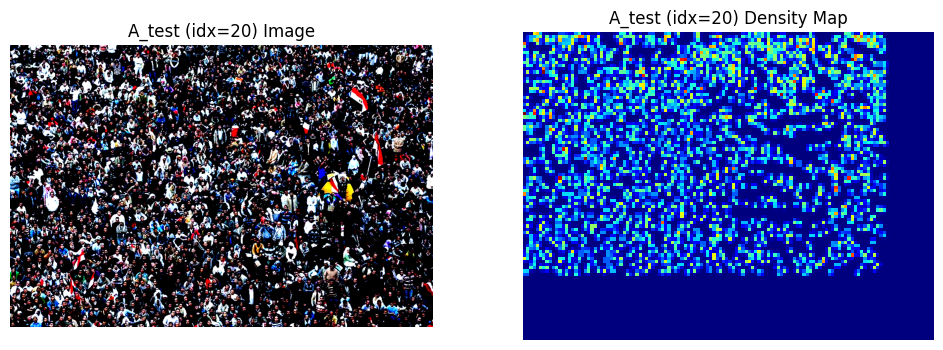

Showing samples from Part B_train


[INFO] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


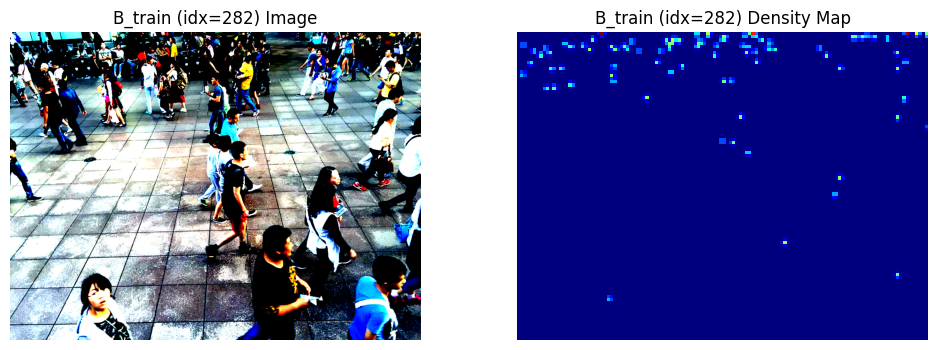

[INFO] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


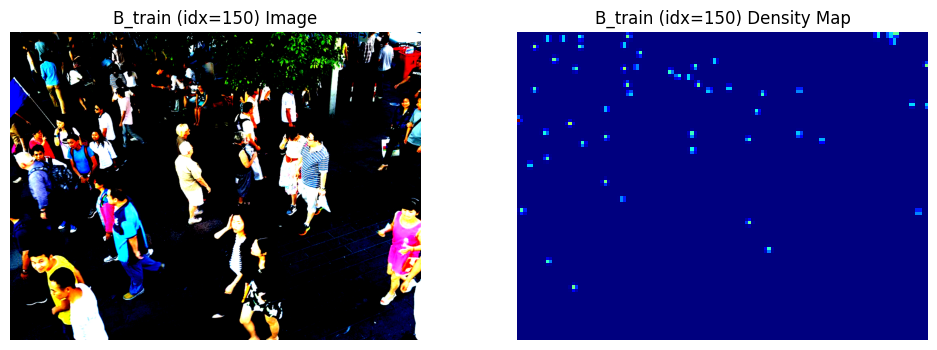

[INFO] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Showing samples from Part B_test


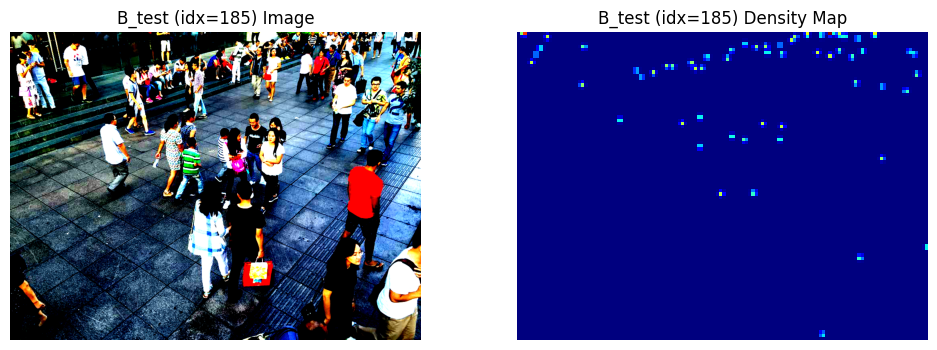

[INFO] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


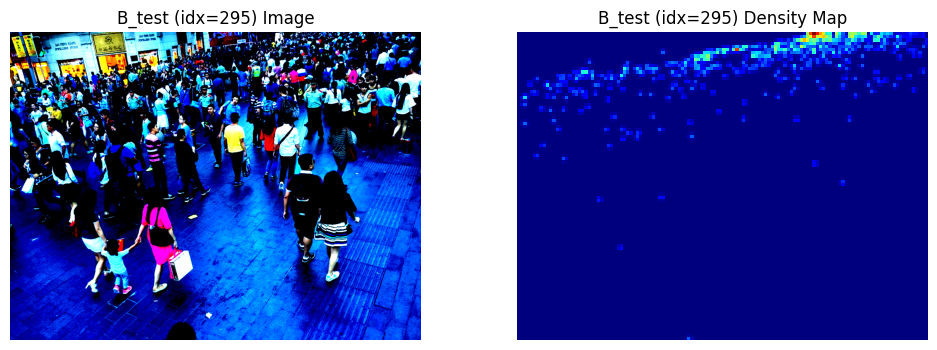

In [21]:
def show_sample(img_t, density_t, title):
    # Convert image tensor to numpy and permute to (H, W, C)
    img = img_t.permute(1, 2, 0).numpy()

    # Convert density map tensor to numpy
    den = density_t.squeeze().numpy()

    # Plot image and density map side by side
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"{title} Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(den, cmap='jet')
    plt.title(f"{title} Density Map")
    plt.axis("off")

    plt.show()

    # Show visualizations from each dataset section
for key in ["A_train", "A_test", "B_train", "B_test"]:
    print(f"Showing samples from Part {key}")

    imgs = all_data[key]["images"]
    dens = all_data[key]["densities"]

    for i in range(2):   # 2 samples per part
        idx = random.randint(0, len(imgs)-1)
        show_sample(imgs[idx], dens[idx], f"{key} (idx={idx})")

In [22]:
# Example: inspect one batch from Part A Train
A_train_imgs = all_data["A_train"]["images"]
A_train_dens = all_data["A_train"]["densities"]

print("Image tensor shape:", A_train_imgs[0].shape)
print("Density tensor shape:", A_train_dens[0].shape)

print("Pixel range:", (A_train_imgs[0].min().item(), A_train_imgs[0].max().item()))
print("Density sum:", float(A_train_dens[0].sum()))


Image tensor shape: torch.Size([3, 768, 1024])
Density tensor shape: torch.Size([1, 96, 128])
Pixel range: (-1.7754088640213013, 2.640000104904175)
Density sum: 1544.1666259765625
